In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function
import io
import ujson as json
import numpy as np
import os
import pandas as pd
import requests
import xml
import xmltodict

# Retrieve IATI Metadata

In [3]:
# Use the IATI registry API to identify the metadata
# http://iatiregistry.org/registry-api

base_url = 'http://iatiregistry.org/api/3/action/package_search'

# Retrieve the current count by issuing a request that returns zero rows

query_data = {
    'q': 'extras_filetype:activity',
    'start': 0,
    'rows': 0
}

response = requests.get(base_url, params = query_data).json()
count = response['result']['count']

# Also print out the help text in case it helps us in the future

print(response['help'])

https://iatiregistry.org/api/3/action/help_show?name=package_search


In [4]:
# Retrieve all the pages of metadata from the cache file (if available)
# or from the server (if no cache file is available)

if os.path.isfile('activities_metadata.json'):
    with io.open('activities_metadata.json', 'r', encoding = 'utf-8') as metadata_file:
        metadata = json.load(metadata_file)
else:
    metadata = []

    # Allowed page size is 100

    for i in range(0, count, 100):
        print('Retrieved', i, 'of', count, 'results')

        query_data = {
            'q': 'extras_filetype:activity',
            'start': i,
            'rows': 100
        }

        response = requests.get(base_url, params = query_data).json()
        metadata.extend(response['result']['results'])

    print('Retrieved', count, 'of', count, 'results')

In [5]:
# Cache the metadata to disk so that we don't have to fetch it

with open('activities_metadata.json', 'w') as metadata_file:
    json.dump(metadata, metadata_file)

# Validate IATI Metadata

In [6]:
# Take a quick look at the field names and get a feel for the data

df = pd.DataFrame(metadata)

df.columns.values

array(['author', 'author_email', 'creator_user_id', 'extras', 'groups',
       'id', 'isopen', 'license_id', 'license_title', 'license_url',
       'maintainer', 'maintainer_email', 'metadata_created',
       'metadata_modified', 'name', 'notes', 'num_resources', 'num_tags',
       'organization', 'owner_org', 'private', 'relationships_as_object',
       'relationships_as_subject', 'resources', 'revision_id', 'state',
       'tags', 'title', 'type', 'url', 'version'], dtype=object)

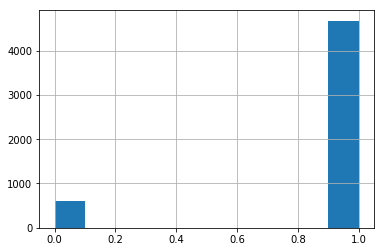

In [7]:
# There's an isopen column indicating whether the data set is open
# to be used for general purposes. Let's see the distribution.

df['isopen'].hist()

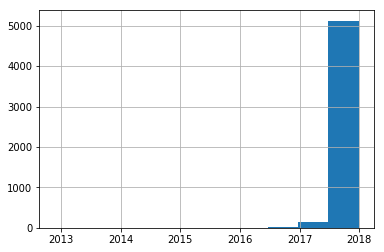

In [8]:
# There is a metadata column on the timestamp when a revision was made,
# which we can use to see if the data is out of date or not.

pd.to_datetime(df['metadata_modified']).hist()

# Identify Resources

In [9]:
# Grab the URLs associated with our metadata

metadata_titles = {}
metadata_resources = {}

for metadata_item in metadata:
    if not metadata_item['isopen']:
        continue

    title = metadata_item['title']
    short_name = metadata_item['name']

    resources = metadata_item['resources']
    resource_urls = [x for x in set([resource_item['url'] for resource_item in resources])]

    metadata_titles[short_name] = title
    metadata_resources[short_name] = resource_urls

# Download Initial

In [10]:
from download_iati import generate_script

generate_script('iati', metadata_titles, metadata_resources)

In [11]:
!chmod u+x download_iati.sh
!./download_iati.sh

In [12]:
from download_iati import reencode_all

reencode_all('iati', metadata_resources)

# Download Missing

In [13]:
!find iati -type f | xargs grep -L activities | xargs rm

In [14]:
def cleanup_empty():
    empty_count = 0
    for xml_name in os.listdir('iati'):
        iati_filename = 'iati/' + xml_name

        if os.path.getsize(iati_filename) == 0:
            empty_count += 1
            os.remove(iati_filename)

    print('Removed %d empty files' % empty_count)

In [15]:
from download_iati import download_all

cleanup_empty()
download_all('iati', metadata_resources)
cleanup_empty()

# Double-Check Files

In [16]:
!find iati -type f | xargs grep -L activities

iati/max-foundation-org.xml
iati/ciuk-0001.xml
iati/utz-org.xml
iati/ccdnigeria-1.xml
iati/aflatoun-apr2015.xml
iati/sida-org.xml


In [17]:
# Report the specific resource URLs we tried.

for short_name, resource_urls in metadata_resources.items():
    iati_filename = 'iati/' + short_name + '.xml'

    if os.path.isfile(iati_filename) and os.path.getsize(iati_filename) > 0:
        continue

    print('Failed to download %s' % short_name)
    print('\n'.join(resource_urls))

Failed to download amnesty-1
http://policehumanrightsresources.org/wp-content/uploads/2017/11/IATIactivitystandaard_89-F.txt
Failed to download ausgov-389
http://dfat.gov.au/data/downloads/Australian_Aid_Regional_File_North_and_Central_America_Unspecified.xml
Failed to download ausgov-189
http://dfat.gov.au/data/downloads/Australian_Aid_Regional_File_North_of_Sahara.xml
Failed to download fco-britishcouncilbc
https://www.gov.uk/government/uploads/system/uploads/attachment_data/file/659940/ODA-British-Council-2016-17-and-Q1-17-18.xml
Failed to download fco-programme
https://www.gov.uk/government/uploads/system/uploads/attachment_data/file/659942/FCO-Programme-Spend-2016-17.xml
Failed to download gl-3
http://genderlinks.org.za/genderlinks-activities.xml
Failed to download globalgiving-activity
http://www.globalgiving.org/iati/activities.xml
Failed to download magariro-gec
https://www.vsointernational.org/sites/default/files/magariro_gec.xml
Failed to download fco-pros-2017-18
https://www

# Remove Files Without Activities

In [18]:
!find iati -type f | xargs grep -L activities | xargs rm

# Create Resource Archive

If running from a Docker container, make sure to run `aws configure` manually to configure your credentials, or it won't be able to upload to the bucket.

In [19]:
s3_bucket = 'mdang.w210'

In [20]:
!rm -f iati.tar.gz
!tar -cf iati.tar iati
!gzip iati.tar
!aws s3 cp iati.tar.gz s3://{s3_bucket}/

upload: ./iati.tar.gz to s3://mdang.w210/iati.tar.gz


In [21]:
!gzip activities_metadata.json
!aws s3 cp activities_metadata.json.gz s3://{s3_bucket}/
!gunzip activities_metadata.json.gz

upload: ./activities_metadata.json.gz to s3://mdang.w210/activities_metadata.json.gz
